# Training on 13,231 events from ACTS. Testing on 3308 events from ACTS.

In [ ]:
!nvidia-smi

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:05:00.0)


### Load in the data.

In [ ]:
%%time
# This is how the ACTS data was cleaned.
# Don't run this cell unless you want to overwrite the current cleaned data.
mapper = {}
for key in range(  30,   35): mapper[key] = 32
for key in range(  70,   75): mapper[key] = 72
for key in range( 115,  120): mapper[key] = 117
for key in range( 170,  175): mapper[key] = 172
for key in range( 255,  270): mapper[key] = 260
for key in range( 355,  370): mapper[key] = 360
for key in range( 495,  510): mapper[key] = 500
for key in range( 655,  670): mapper[key] = 660
for key in range( 815,  830): mapper[key] = 820
for key in range(1010, 1030): mapper[key] = 1020

print("Loading in the frame.")
filepath   = "data/sets/progenitors/ACTS.gz"
events     = utils.list_of_groups(pd.read_csv(filepath), "event_id")
frame      = pd.concat([event for event in events if metrics.number_of_tracks(event) <= 25])
frame["r"] = frame["r"].round().map(mapper)
frame.drop_duplicates(["event_id", "cluster_id", "r"], keep="first", inplace=True)
print("Preparing the frame.")
frame = ext.prepare_frame(frame, n_tracks=25, n_rows=250, n_noise=0)
frame = frame.sample(frac=1)  # Shuffle the set.
print(frame["cluster_id"].max())
print("Saving the frame.")
frame.to_csv("data/sets/ACTS-25T-250R.gz", compression="gzip")

In [2]:
%%time
modelpath = "data/models/ACTS-25T-250R.h5"
filepath  = "data/sets/ACTS-0N-25T-16539E-250R.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py") 

Train is list of 13232 events.
Test is list of 3308 events.
Train takes up 105920 bytes.
Test takes up 26528 bytes.
CPU times: user 6.66 s, sys: 6.72 s, total: 13.4 s
Wall time: 13.4 s


In [3]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [ ]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

In [ ]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

### Show an example of the data.

In [ ]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [ ]:
visuals.display(train[n], order)

### Create the model.

In [5]:
input_shape  = (250, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [4]:
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

### Fit the model.

In [ ]:
%%time
# 128 + 32
epochs     = 128
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

### Display information about the model after fitting it.

In [6]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 97.41891855700474%
Percent of tracks assigned correctly: 93.81047268842828%
Percent of events with the correct number of tracks: 95.34461910519951%
CPU times: user 1min 35s, sys: 176 ms, total: 1min 36s
Wall time: 1min 36s


### Display how one of the model's predictions looks.

In [ ]:
n  = 3138  # np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

In [ ]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

In [ ]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

In [ ]:
%%time
for percent in [0.3, 0.5, 0.75, 1.0]:
    c_tracks = [metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order, percent=percent)
                for n in range(len(guesses))]
    boxes = [[] for _ in r]
    for i in range(len(c_tracks)):
        index = metrics.number_of_tracks(test[i]) - 1
        boxes[index].append(c_tracks[i])
    visuals.boxplot(
        boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks",
        "Percent of Tracks Correctly Assigned ({})".format(percent), xticks=list(r))

In [ ]:
%%time
thresholds = [i / 10 for i in range(11)]
threshold_metrics = [[metrics.threshold_metrics(test[i], guesses[i], n, order)
                      for i in range(len(guesses))] for n in thresholds]
boxes_correct   = [[m[0] for m in metric] for metric in threshold_metrics]
boxes_incorrect = [[m[1] for m in metric] for metric in threshold_metrics]
boxes_multi     = [[m[2] for m in metric] for metric in threshold_metrics]
boxes_none      = [[m[3] for m in metric] for metric in threshold_metrics]
visuals.boxplot(
    boxes_correct, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to correct track]", xticks=thresholds)
visuals.boxplot(
    boxes_incorrect, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to an incorrect track]", xticks=thresholds)
visuals.boxplot(
    boxes_multi, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to multiple tracks]", xticks=thresholds)
visuals.boxplot(
    boxes_none, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to no tracks]", xticks=thresholds)

In [ ]:
bad_tracks = []
for i in range(len(test)):
    if ext.extract_output(test[i], order)[0, 0] == 1:
        bad_tracks.append(test[i])
bad_guesses = model.predict(ext.extract_input(bad_tracks, order))
print(metrics.percent_of_hits_assigned_correctly(bad_tracks, bad_guesses, order))

<IPython.core.display.Javascript object>


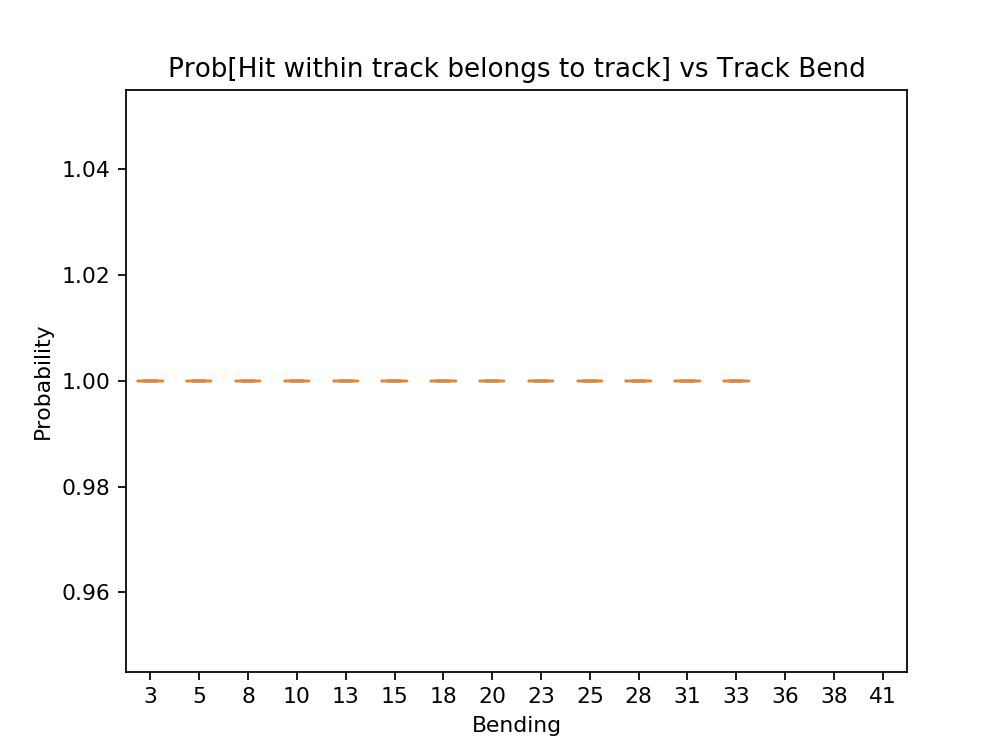

In [42]:
def angle_distance(a, b):
    angle = np.abs(a % (2 * np.pi) - b % (2 * np.pi))
    return (angle) if (angle < np.pi) else (2 * np.pi - angle)

bins = [[] for _ in range(16)]
for event_id, event in enumerate(test[:50]):
    guess  = metrics.discrete(guesses[event_id])
    truth  = ext.extract_output(event, order)
    tracks = (track for (_, track) in event.groupby("cluster_id"))
    for track_id, track in enumerate(tracks):
        if track["noise"].any() or track["padding"].any():
            continue
        lowp  = track[track["r"] == track["r"].min()]["phi"].min()
        highp = track[track["r"] == track["r"].max()]["phi"].min()
        bend  = angle_distance(lowp, highp)
        right = np.logical_and(guess[:, track_id], truth[:, track_id]).sum()
        index = int(bend // (np.pi / (8 * len(bins))))
        bins[index].append(right / len(track))
visuals.boxplot(
    bins,
    ylabel = "Probability",
    xlabel = "Bending",
    title  = "Prob[Hit within track belongs to track] vs Track Bend",
    xticks = [round(1 / (np.pi / (8 * (x + 1)))) for x in range(len(bins))]
)